Notebook pour appliquer l'extraction des motifs temporels extraits à avec un treshold de -65dB sur les données traitées à -85dB.

L'objectif est de faire ressortir les motifs qui sont supposement des groupes réels : des groupes de vaches qui apparaissent plusieurs fois ensemble pendnat la collecte des données.


In [ ]:
# Importation des librairies
from TRACE_module.motif import *
import TRACE_module.preprocessing as pp
from TRACE_module.descriptive_analysis import sort_stack_by_timesteps
from TRACE_module.egocentric import *
import pandas as pd
import os 
import sys
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt

In [114]:
### Importation des paths à partir du .env
load_dotenv()
parent_dir_raw = os.getenv("parent_folder")
parent_dir = os.sep.join([parent_dir_raw])

output_dir_raw = os.getenv("output_dir")
output_dir = os.sep.join([output_dir_raw])

print(f"Data directory : {parent_dir} | Output dir : {output_dir}")

Data directory : ./data/data_Buisson | Output dir : ./savings


In [115]:
# Parsing de la liste des fichiers parquet
list_files = []
for f in os.listdir(parent_dir): 
    if f.endswith(".parquet") : 
        list_files.append(os.path.join(parent_dir,f))

len(list_files), list_files

(46,
 ['./data/data_Buisson/20241016-20241029_3ce9_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cea_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cf6_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cf8_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d06_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d08_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d0c_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d05_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3ceb_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3667_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3669_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cfc_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cf5_glob_sensor_time_ble.parq

In [116]:
## Dossier pour enregistrer les données
if not  os.path.isdir(output_dir) : 
    os.makedirs(output_dir)

In [117]:
# Importation des données sous forme de dataframe pandas
data=pp.concatenate_df(list_files, smooth_time="20s")
list_id=list(pd.unique(data["accelero_id"]))

In [118]:
#Data_filtering Buisson 
start = "2024-10-16T15:00:00"
end = "2024-10-29T06:00:00"

data = data.loc[(data["glob_sensor_DateTime"] >= start) & (data["glob_sensor_DateTime"] <= end)]

In [ ]:

THRESH_DB = -85 # Threshold pour l'extraction des motifs 

# Traitement des données à -65dB
stack_matrice_65db, list_timestep_65db = pp.create_stack(dataframe=data, list_id=list_id, threshold=-65)
stack_matrice_65db, list_timestep_65db = sort_stack_by_timesteps(stack_matrice_65db, list_timestep_65db)

# Traitement des données au threshold où l'on va extraire les motifs à postériori
stack_matrice_85db, list_timestep_85db = pp.create_stack(dataframe=data, list_id=list_id, threshold=THRESH_DB)
stack_matrice_85db, list_timestep_85db = sort_stack_by_timesteps(stack_matrice_85db, list_timestep_85db)

In [ ]:
# Transformation des stacks en liste de motifs
df_motif_65db = stack_to_df_motif(stack_matrice_65db, list_timestep_65db, list_id)
df_motif_85db = stack_to_df_motif(stack_matrice_85db, list_timestep_85db, list_id)

In [ ]:
# Comptage des motifs à l'aide d'un compteur (similaire à un dictionnaire)
# On ne compte que les composantes connexes dans notre cas
from collections import Counter

# Extraction des motifs à -65db
counts_motif_65db = Counter()
for motif in df_motif_65db["motif"] : 
    components = motif.connected_components() #Extraction des composantes connexes
    for comp in components :
        counts_motif_65db[comp] +=1 

# Extraction des motifs à -85db
counts_motif_85db = Counter()
for motif in df_motif_85db["motif"] : 
    components = motif.connected_components()
    for comp in components :
        counts_motif_85db[comp] +=1 

In [ ]:
# Récupération des toutes les composantes connexes
list_connected_components_65db = list(counts_motif_65db.keys())
list_connected_per_ts_85db = mat_stack_to_list_connected_components(stack_matrice_85db, list_id)

In [ ]:
### On effectue un premier tri des motifs
NB_MIN_INTER = 30 # Nombre minimal des intéractions à avoir dans toute la période de collecte des données

# Conversion en DataFrame les counts des composantes connexes
df_counts_motif = pd.DataFrame({"motif" : counts_motif_65db.keys(), "counts" : counts_motif_65db.values()})

filtered_counts = df_counts_motif[df_counts_motif["counts"] >= NB_MIN_INTER]

In [ ]:
# Création des masques associé à chaque motif
masks_all_comp = masks_all_components(list(filtered_counts["motif"]), list_connected_per_ts_85db)

100%|██████████| 1091/1091 [32:19<00:00,  1.78s/it]


In [ ]:
# Transformation en dataframe pandas pour une manipulation plus simple 
df_masks = pd.DataFrame({"motif" : masks_all_comp.keys(), "mask" : masks_all_comp.values})

In [ ]:
## Fonction qui permet de compter le nombre de séquences d'intéractions continue avec un erreur possible
MAX_GAP = 2 #Nombre de zeros tolérés entre 2 suites de '1' pour qu'on considère les 2 comme étant une seule séquence

### Si MAX == 2 : 
# La séquence (0,0,0,0,1,1,1,0,0,1,1,1,1,0,0) aura un comptage de 1 séquence d'intération
# Mais la séquence : (0,0,0,0,1,1,1,0,0,0,1,1,1,0,0) aura un commptage de 2 séquences d'intéractions 

def fuzzy_count_all_masks(masks_all_comp, max_gap):
    fuzzy_counts = dict()
    for comp,mask in masks_all_comp.items(): 
        fuzzy_counts[comp] = count_fuzzy_sequences_of_ones(mask, max_gap)
    return fuzzy_counts

fuzzy_counts = fuzzy_count_all_masks(masks_all_comp, MAX_GAP)
df_fuzzy_counts = pd.DataFrame({"motif" : fuzzy_counts.keys(), "fuzzy_counts" : fuzzy_counts.values()})

In [ ]:
# Filtre de la taille des motifs 
MIN_LEN_COMP = 3 #Nombre d'arrêtes minimum à selectionner
filtered_fuzzy_counts = dict((k, fuzzy_counts[k]) for k in fuzzy_counts.keys() if len(k) >= MIN_LEN_COMP)
df_filtered_fuzzy_counts = pd.DataFrame({"motif" : filtered_fuzzy_counts.keys(), "fuzzy_counts" : filtered_fuzzy_counts.values()})
df_filtered_fuzzy_counts.sort_values(by="fuzzy_counts", ascending=False, inplace=True)

In [ ]:
# Récupération de la longueur des motifs
df_filtered_fuzzy_counts["len_motif"] = df_filtered_fuzzy_counts["motif"].apply(len)
df_filtered_fuzzy_counts.shape

(22, 3)

<Axes: ylabel='Frequency'>

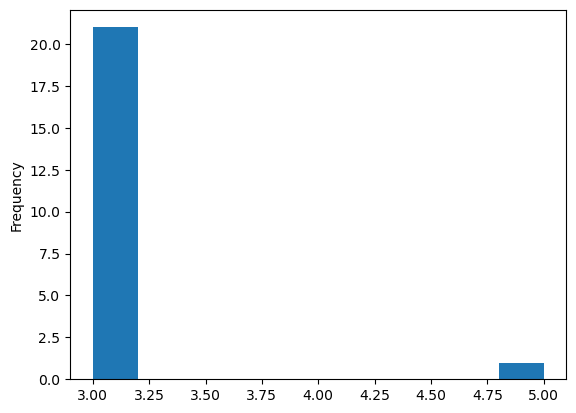

In [ ]:
# Plot de la longueur des motifs extraits
df_filtered_fuzzy_counts["len_motif"].plot(kind = "hist")

In [ ]:
motif_filtered = list(df_filtered_fuzzy_counts["motif"])
len(motif_filtered), motif_filtered

(22,
 [Motif( 3cea -- 3cf0, 3cea -- 3cff, 3cf0 -- 3cff, oriented : False),
  Motif( 3cee -- 3cf7, 3cee -- 3cff, 3cf7 -- 3cff, oriented : False),
  Motif( 3662 -- 3cf7, 3662 -- 3cff, 3cf7 -- 3cff, oriented : False),
  Motif( 3667 -- 3668, 3667 -- 3d02, 3668 -- 3d02, oriented : False),
  Motif( 366c -- 3cfc, 366c -- 3cff, 3cfc -- 3cff, oriented : False),
  Motif( 3cf3 -- 3cf7, 3cf3 -- 3cfc, 3cf7 -- 3cfc, oriented : False),
  Motif( 3cf4 -- 3d03, 3cf4 -- 3d04, 3d03 -- 3d04, oriented : False),
  Motif( 3665 -- 3ceb, 3665 -- 3cfa, 3ceb -- 3cfa, oriented : False),
  Motif( 3cf7 -- 3cfd, 3cf7 -- 3d06, 3cfd -- 3d06, oriented : False),
  Motif( 3cea -- 3cfb, 3cea -- 3cfd, 3cfb -- 3cfd, oriented : False),
  Motif( 3665 -- 3cea, 3665 -- 3cfb, 3cea -- 3cfb, oriented : False),
  Motif( 3cfa -- 3d03, 3cfa -- 3d05, 3d03 -- 3d05, oriented : False),
  Motif( 3ceb -- 3cfe, 3ceb -- 3d01, 3cfe -- 3d01, oriented : False),
  Motif( 3cec -- 3cf7, 3cf3 -- 3cf7, 3cf7 -- 3cfc, oriented : False),
  Motif( 3cf4 -

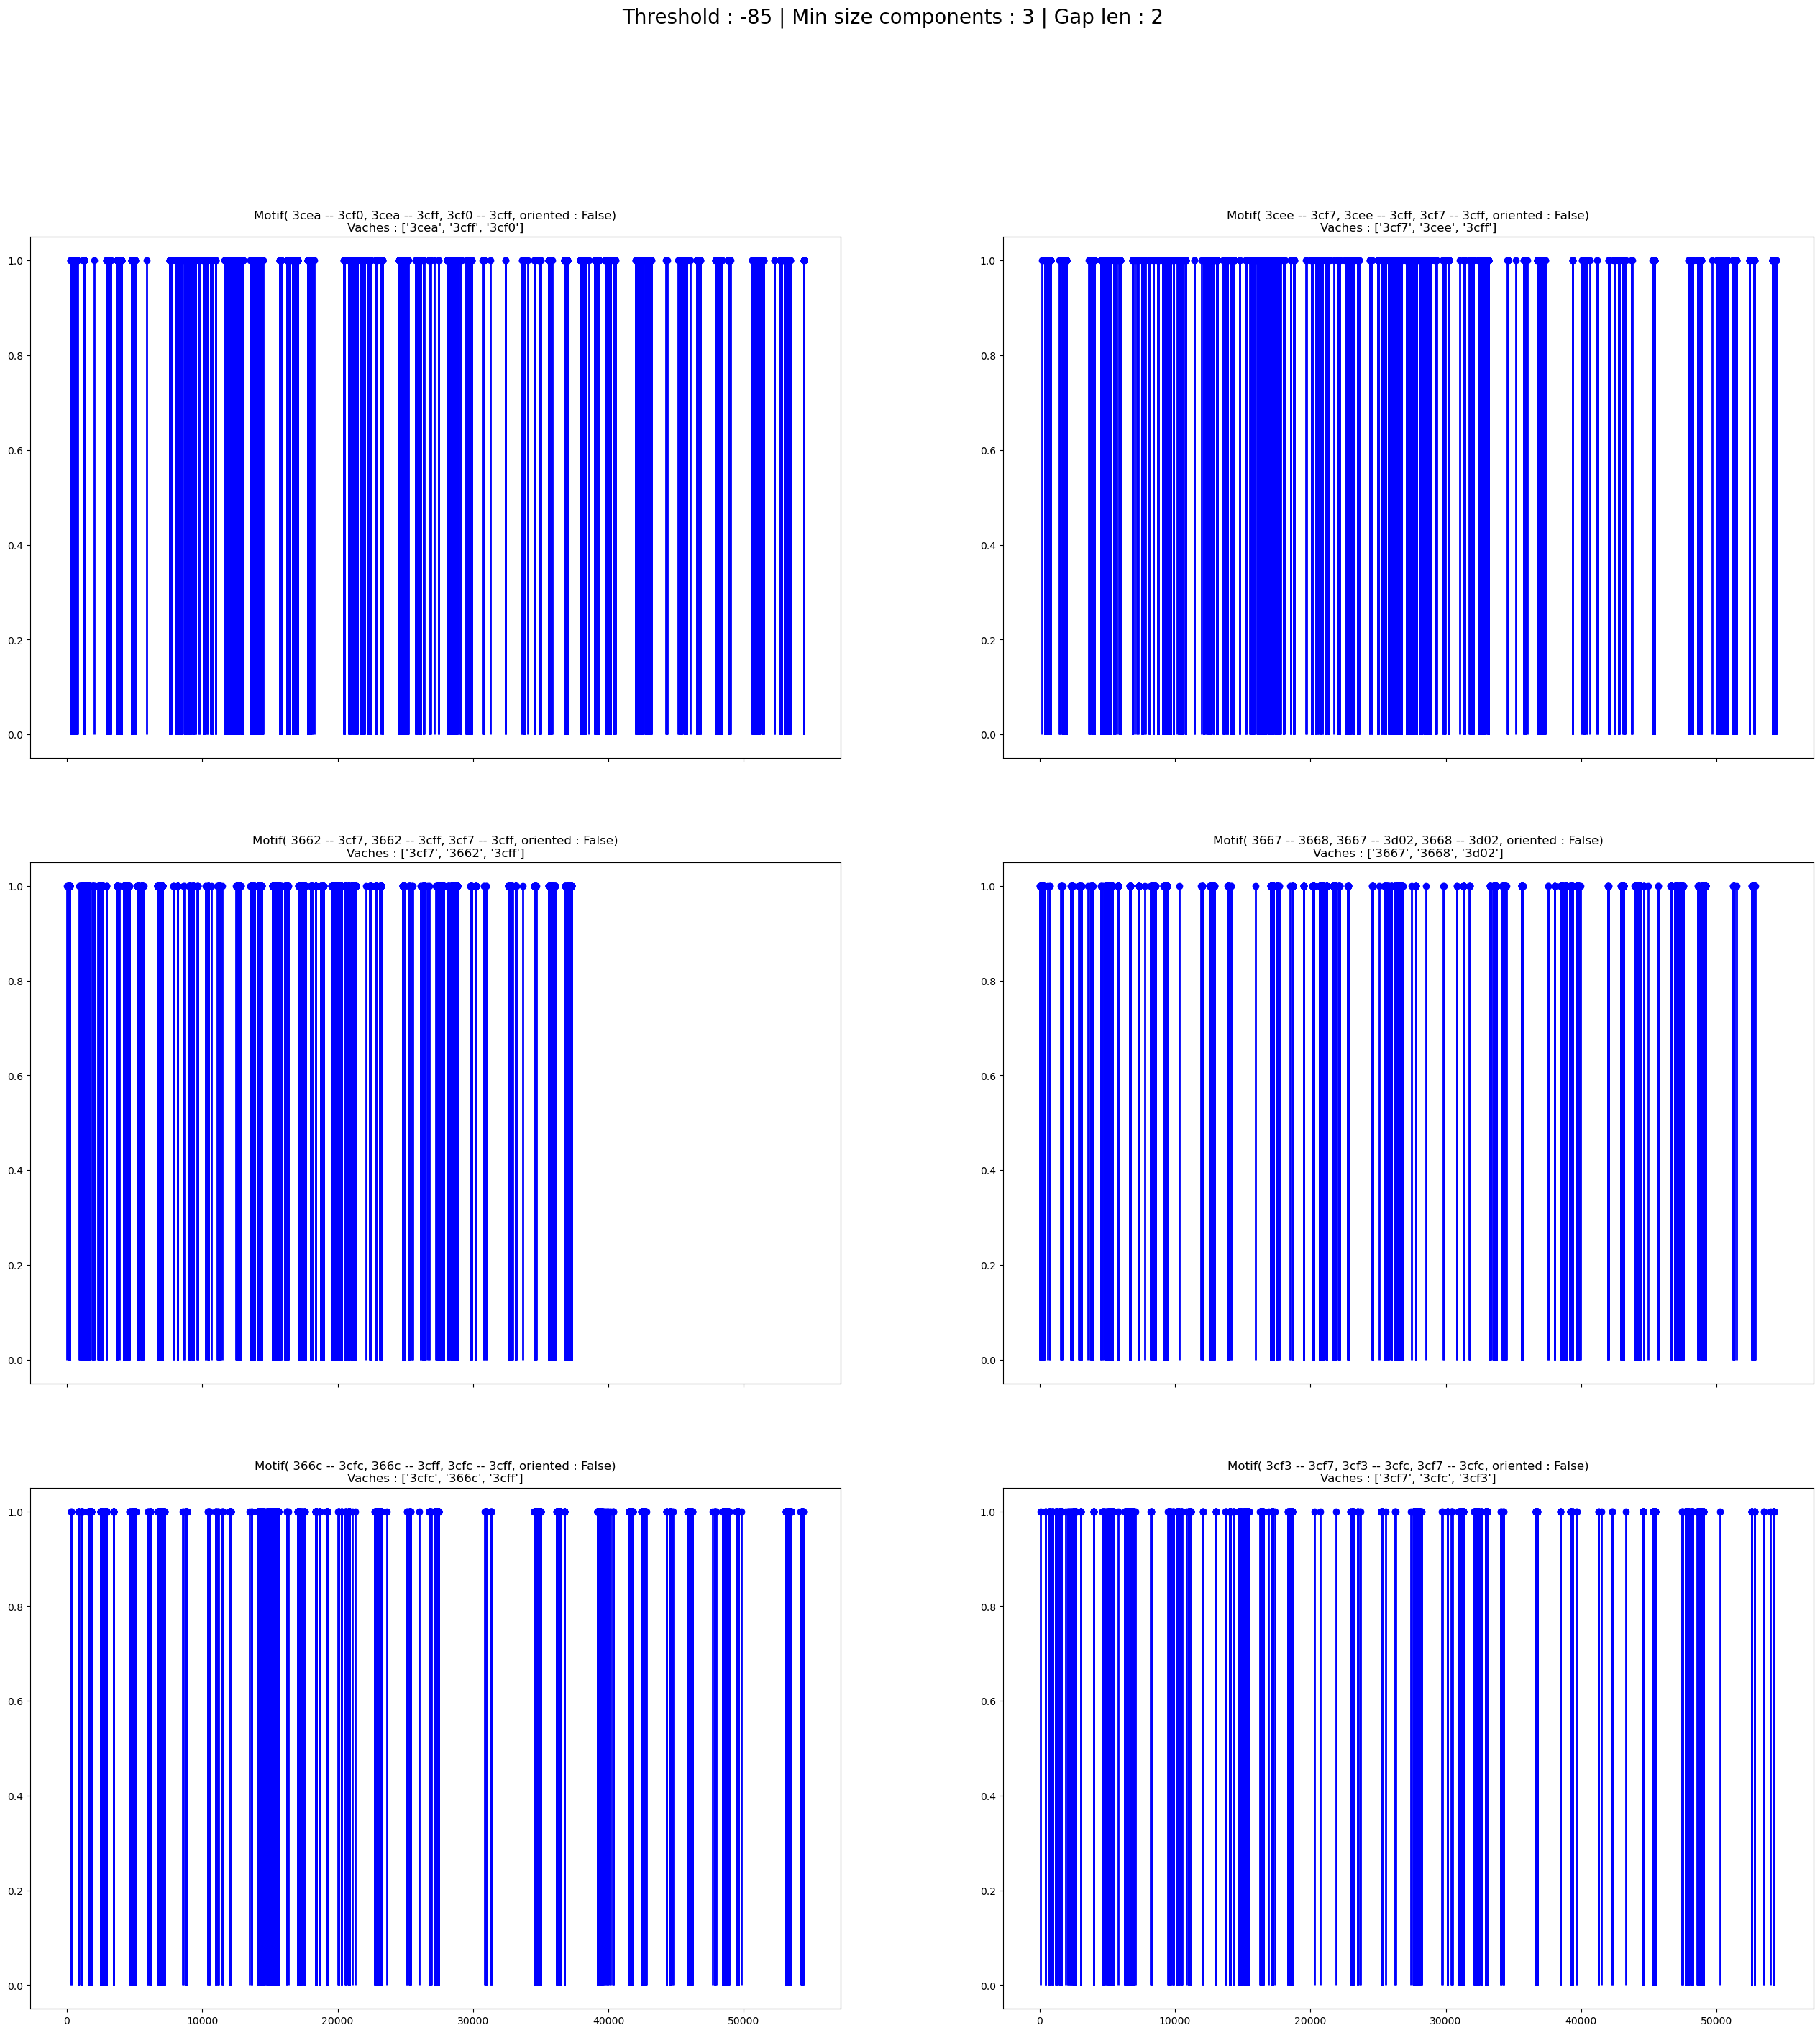

In [ ]:
# Plot des composnates
fig, axes = plt.subplots(3,2, figsize=(32,32), sharex=True)
fig.suptitle(f"Threshold : {THRESH_DB} | Min size components : {MIN_LEN_COMP} | Gap len : {MAX_GAP}", fontsize=20)
NB_TIMESTEP = len(masks_all_comp[motif_filtered[0]])
ticks = np.arange(0,NB_TIMESTEP, 100)
for ind,ax in enumerate(axes.ravel()):
    comp = motif_filtered[ind]
    mask_comp = masks_all_comp[comp]
    indices = np.where(mask_comp == 1)[0]
    ax.vlines(indices, ymin=0, ymax=1, color='b', lw=2)
    ax.scatter(indices, np.ones_like(indices), color='b', marker='o', label="1 détecté")
    ax.set_title(str(comp) + "\n" + f"Vaches : {str(comp.get_nodes())}" )

Motif( 3cea -- 3cf0, 3cea -- 3cff, 3cf0 -- 3cff, oriented : False)
['3cea', '3cff', '3cf0']
14 [datetime.date(2024, 10, 16) datetime.date(2024, 10, 17)
 datetime.date(2024, 10, 18) datetime.date(2024, 10, 19)
 datetime.date(2024, 10, 20) datetime.date(2024, 10, 21)
 datetime.date(2024, 10, 22) datetime.date(2024, 10, 23)
 datetime.date(2024, 10, 24) datetime.date(2024, 10, 25)
 datetime.date(2024, 10, 26) datetime.date(2024, 10, 27)
 datetime.date(2024, 10, 28) datetime.date(2024, 10, 29)]


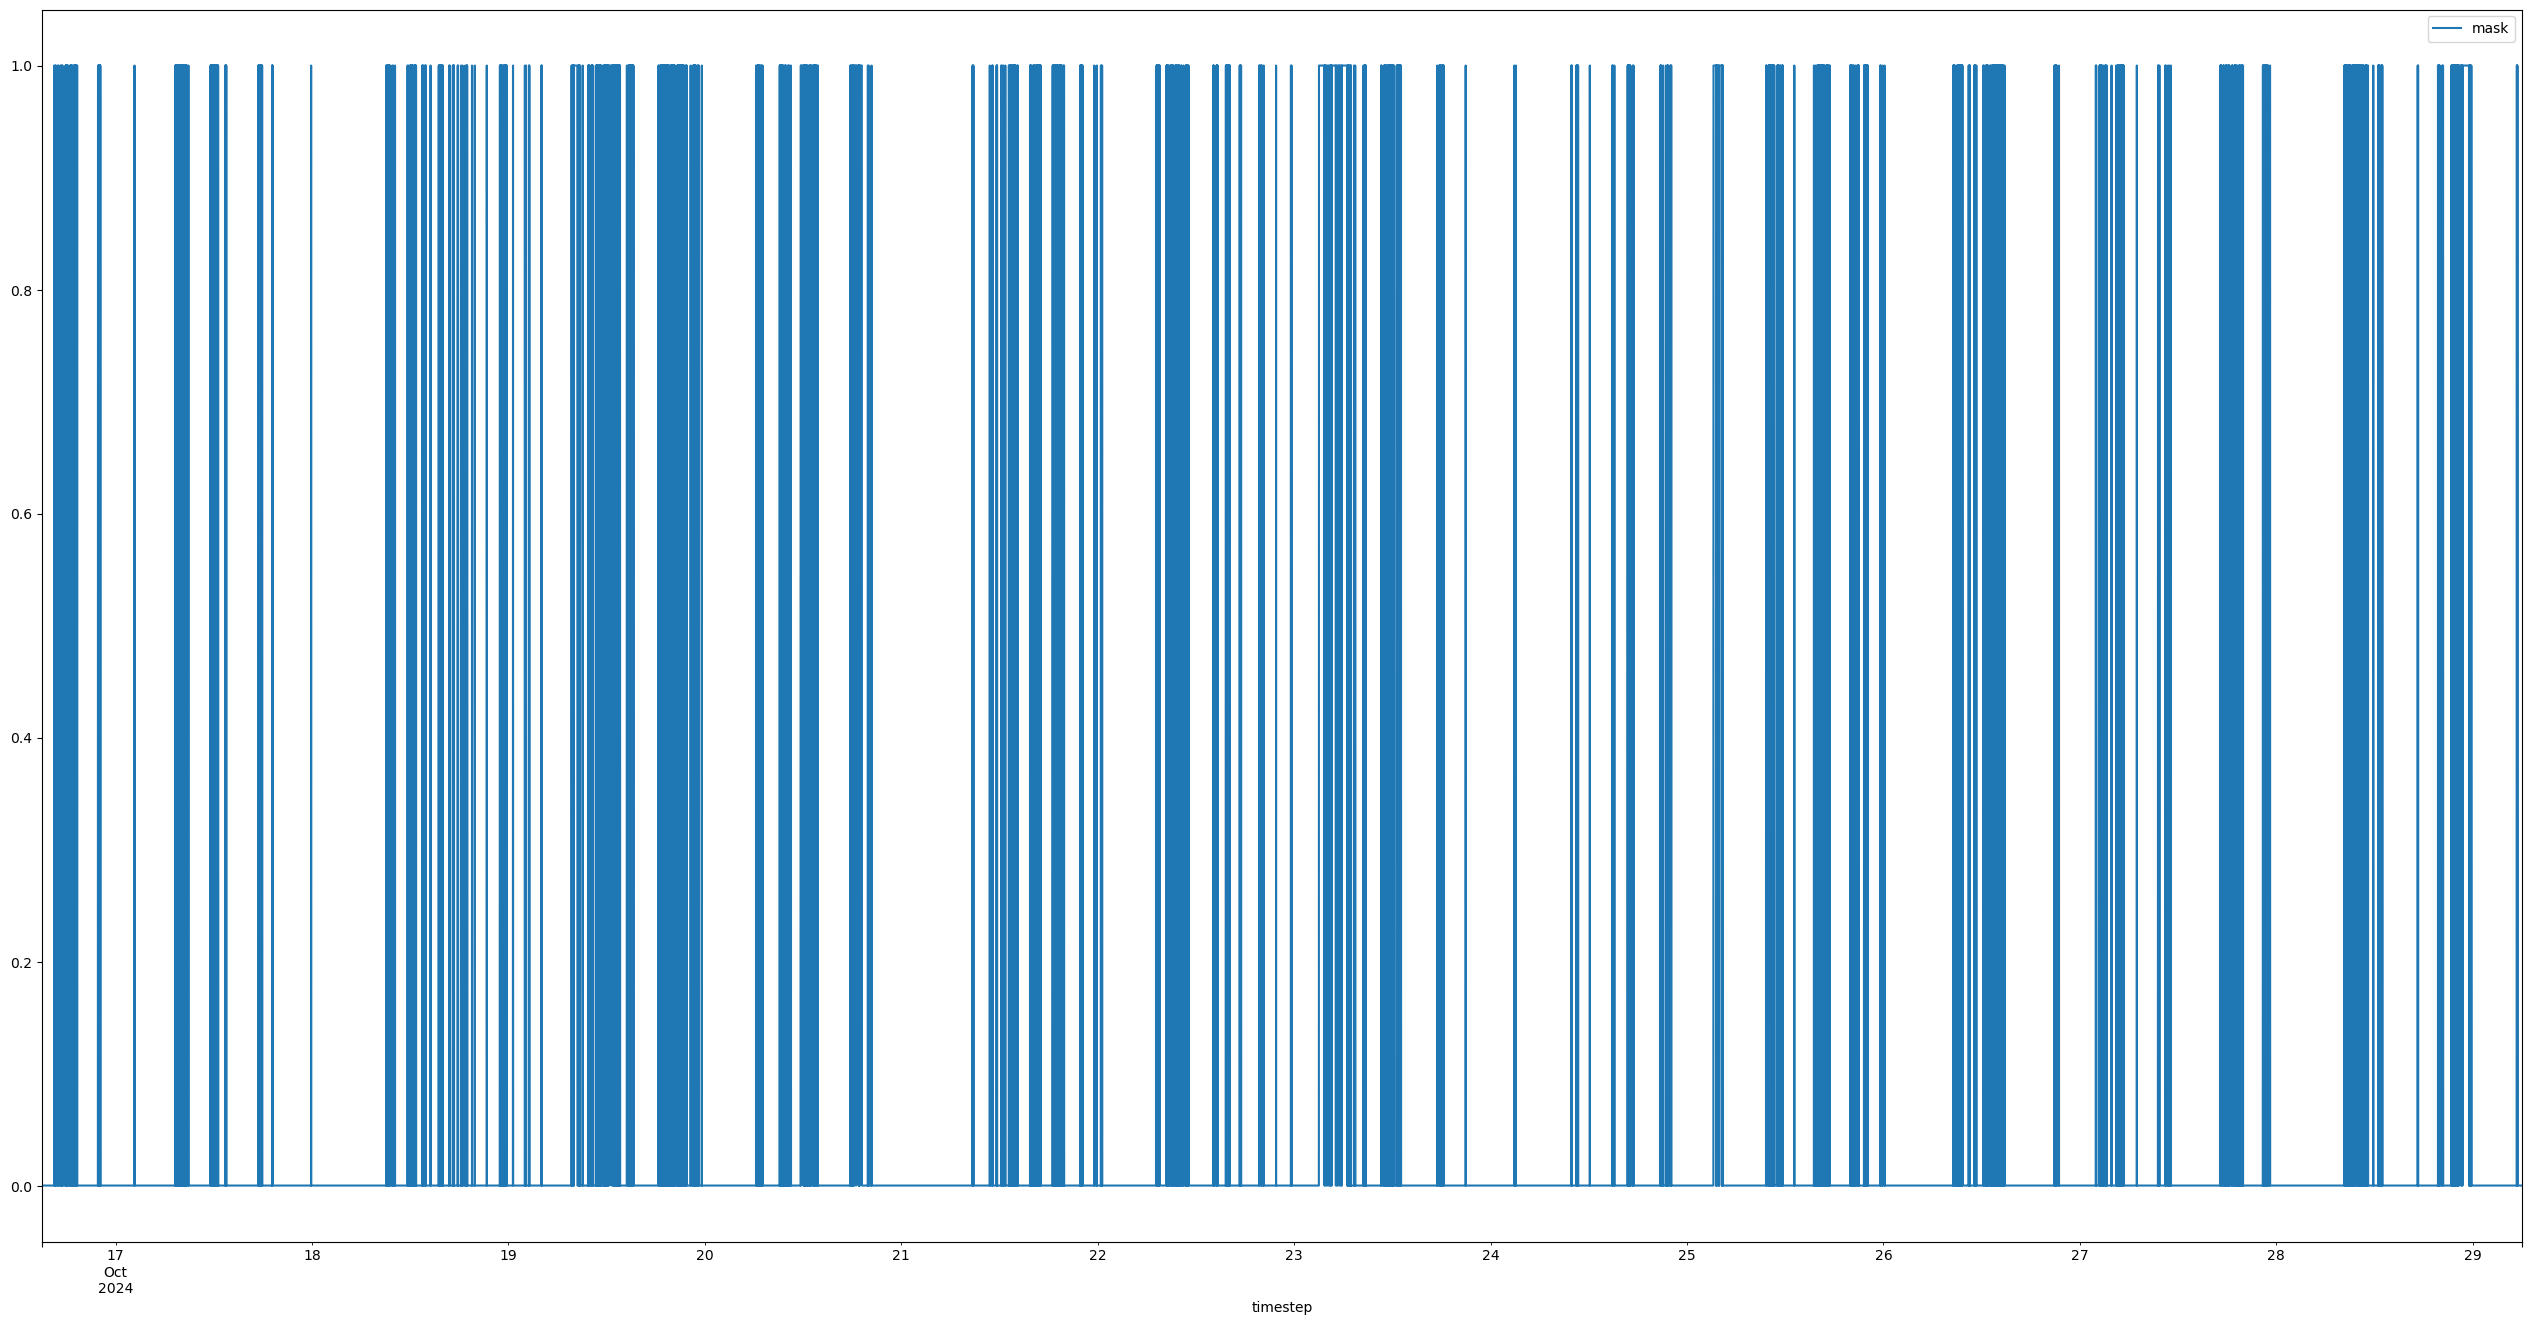

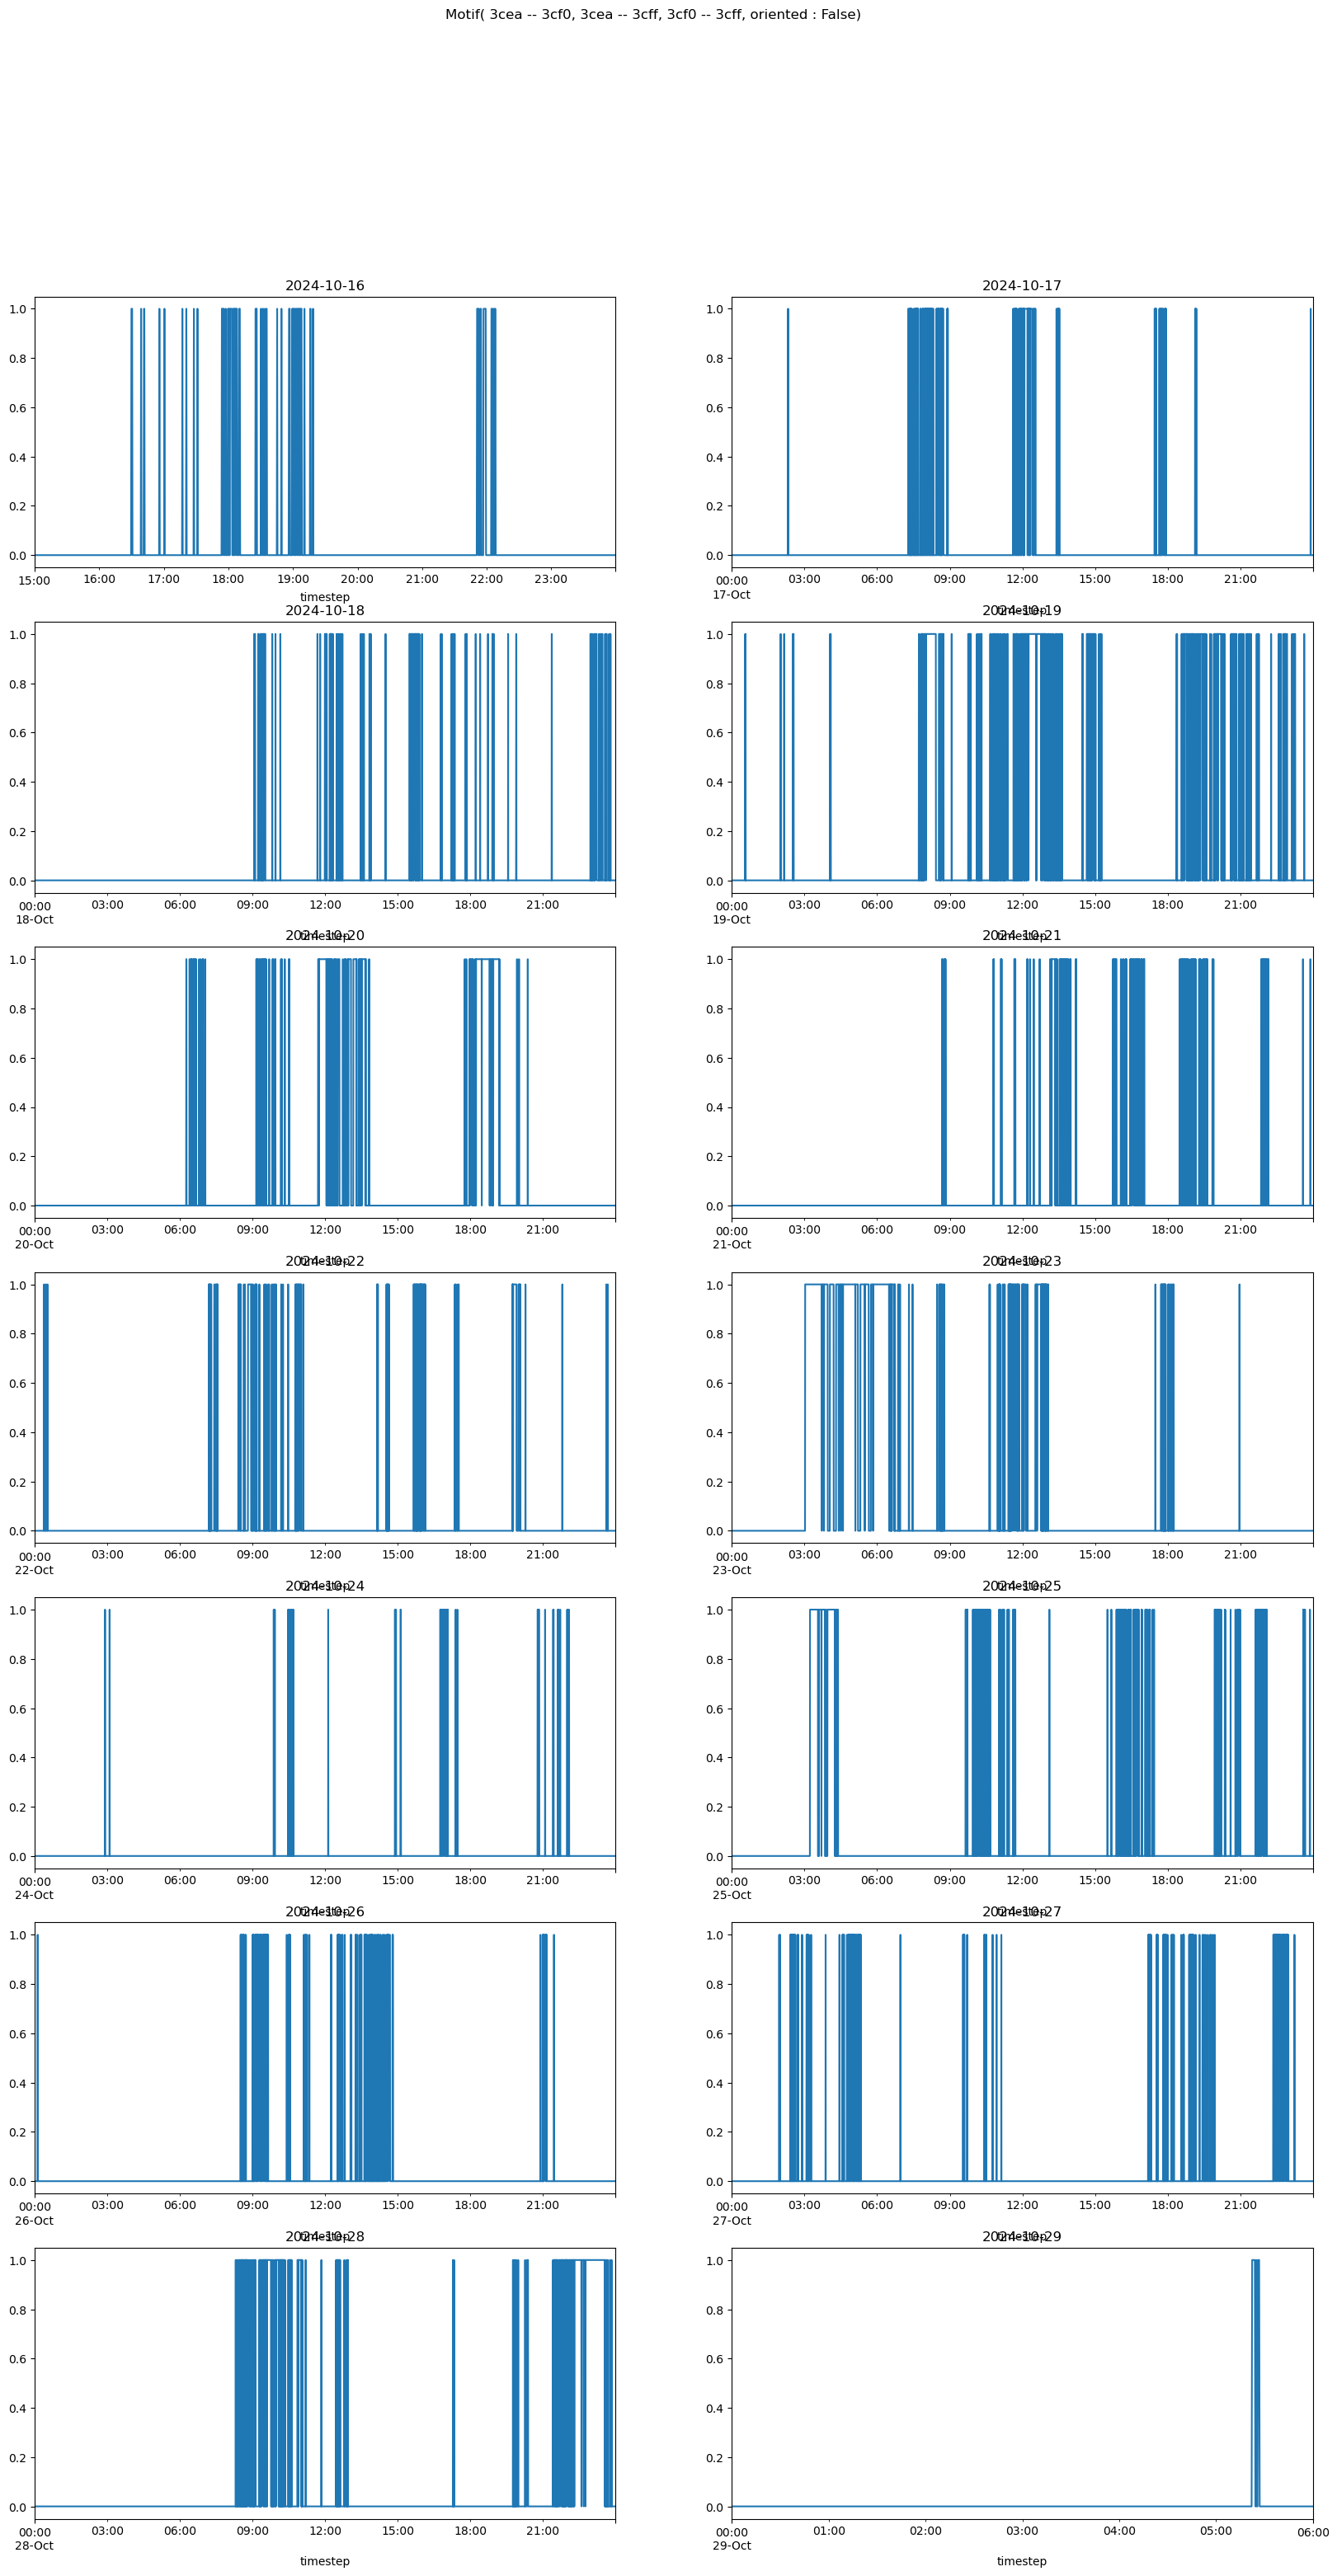

In [ ]:
## Plot d'un seul motif par jour
motif = motif_filtered[0]
mask_motif = masks_all_comp[motif]
print(motif)
print(motif.get_nodes())

df_mask_motif = pd.DataFrame({"timestep" : list_timestep_65db, "mask" : mask_motif})
df_mask_motif.set_index("timestep").plot(figsize=(32,16))
df_mask_motif["date"] = df_mask_motif["timestep"].dt.date
days = pd.unique(df_mask_motif["date"])
print(len(days), days)

fig, axes = plt.subplots((len(days)// 2) , 2 )
fig.suptitle(f"{motif}")
fig.set(figheight= 5*((len(days) // 2)), figwidth= 20)
for ind,ax in enumerate(axes.ravel()) :
    day = days[ind]
    df_day = df_mask_motif[df_mask_motif["date"] == day]
    df_day.set_index("timestep")["mask"].plot(ax=ax)
    ax.set_title(str(day))